# National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook generates Geoscience Australia's (GA) National Intertidal Digital Elevation Model (NIDEM) datasets, which provide continuous elevation data for Australia's intertidal zone. It initially imports layers from the GA Intertidal Extents Model (ITEM v2.0) and median tidal elevations for each tidal interval, computes elevations at interval boundaries, extracts contours around each tidal interval, and then interpolates between these contours using TIN/Delaunay triangulation linear interpolation. This interpolation method preserves the tidal interval boundaries of ITEM v2.0. The notebook produces several output files:

1. Contour line shapefiles (`NIDEM_contours_XXX.shp`) used for the interpolation. These datasets facilitate re-analysis by allowing DEMs to be generated using alternative interpolation methods.
2. Mask geotiff rasters (`NIDEM_mask_XXX.tif`) that flag cells with elevations greater than 25m (1), less than -25m (2), and ITEM confidence NDWI standard deviation greater than 0.25 (3). These masks were used to filter the output NIDEM layers.
3. Unfiltered NIDEM geotiff rasters (`NIDEM_unfiltered_XXX.tif`) with elevations in mm units relative to Mean Sea Level.
4. Filtered NIDEM geotiff rasters (`NIDEM_dem_XXX.tif`) with elevations in mm units relative to Mean Sea Level that have been cleaned by masking out cells included in the mask layers. This is the primary output product, and is expected to be the default product used for most applications.

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [61]:
# Import libraries
import sys
import os
import glob
import itertools
import fiona
import numpy as np
import pandas as pd
import collections
import scipy.interpolate 
import skimage.measure
from osgeo import gdal
from scipy import ndimage as nd
from pyproj import Proj, transform
from fiona.crs import from_epsg
from shapely.geometry import LineString, MultiLineString, mapping
from matplotlib import pyplot as plt
from IPython.display import display

# Import DEA Notebooks scripts
sys.path.append('/g/data/r78/rt1527/dea-notebooks/Scripts')
import SpatialTools 


## Set up analysis
Set up path to data and polygon to process. `plotting_subset` does not affect the analysis, but can be used to provide more useful zoomed-in plots.

In [62]:
# Working directory
os.chdir("/g/data/r78/rt1527/nidem")

# Define path to ITEM offset product
item_offset_path = '/g/data2/v10/ITEM/offset_products'
item_relative_path = '/g/data2/v10/ITEM/rel_products'
item_conf_path = '/g/data2/v10/ITEM/conf_products'

# Define paths to external datasets
gbr30_raster = '/g/data/r78/rt1527/datasets/GBR30/02_ESRI_Raster/gbr30_ALL/gbr30_all'
ausbath09_raster = '/g/data/r78/rt1527/datasets/ausbath_09/ausbath_09_v4'
srtm30_raster = '/g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0'
manually_included_shp = 'scratch/manual_mask.shp'

# Set ITEM polygon for analysis
polygon_ID = 96
# Issues with # 18, 131, 162, 172, 204, 220, 226, 238, 240, 301

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[3050: 3950, 2250:3150]

# Print run details
print('Processing polygon {} from {}'.format(polygon_ID, item_offset_path))

Processing polygon 96 from /g/data2/v10/ITEM/offset_products


## ITEM interval boundary value extraction
ITEM offset values represent the median tidal height for each tidal interval ([Sagar et al. 2015](https://doi.org/10.1016/j.rse.2017.04.009)). Because ITEM tidal intervals are linearly spaced by design, this code uses a simple linear model to compute new offset values for each interval boundary (e.g. the boundary between ITEM interval 1 and 2). This allows us to assign a more appropriate tidal height to the contours that divide the ITEM tidal intervals than would be possible through simply assigning median tidal heights to the downhill or uphill contours. 

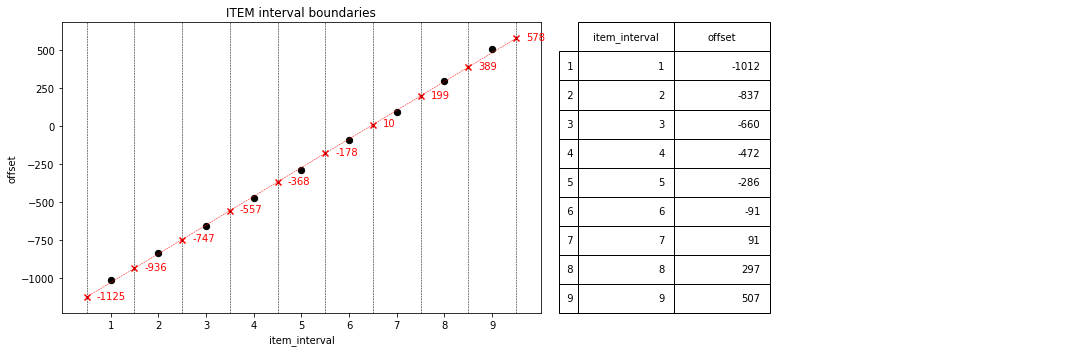

In [63]:
# Import ITEM offset values for each ITEM tidal interval
item_offsets = np.loadtxt('{}/elevation.txt'.format(item_offset_path), delimiter = ',', dtype = 'str')
item_offsets = {int(key):[int(val) for val in value.split(" ")] for (key, value) in item_offsets}
interval_offsets = item_offsets[polygon_ID]

# Create dataframe of offset values by ITEM interval
interval_offsets_df = pd.DataFrame({'item_interval': range(1,10), 'offset': interval_offsets})

# Compute linear model and calculate ITEM offsets at the boundary of each ITEM interval 
# (ensures that extracted contours are placed precisely on the boundary of ITEM intervals)
m, b = np.polyfit(interval_offsets_df['item_interval'], interval_offsets_df['offset'], 1)
interval_boundaries = np.arange(0.5, 10.5, 1.0)
contour_offsets = (m * interval_boundaries + b).astype(int)

# Compute ITEM offset interval used to fill lowest class of ITEM relative layer 
# (not used for interpolation, but ensures lowest contour is placed exactly on interval boundary)
interval_zero = (m * 0 + b).astype(int)

# Plot output
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
interval_offsets_df.plot(kind='scatter', x='item_interval', y='offset', s = 40, 
                         color='black', xticks=interval_offsets_df['item_interval'], ax=ax1)
ax1.scatter(interval_boundaries, contour_offsets, color='red', marker='x')
ax1.plot(interval_boundaries, contour_offsets, color='red', linestyle='--', lw=0.5)
for xc in interval_boundaries:
    ax1.axvline(x=xc, color='k', linestyle='--', lw=0.5)
for i, txt in enumerate(contour_offsets):
    ax1.annotate(txt, xy=(interval_boundaries[i], contour_offsets[i]), 
                 xytext=(10, -2), textcoords='offset points', color='red')
ax1.set_title('ITEM interval boundaries')
fig.tight_layout()

# Display table of offset values for each interval
ax2.axis('off')
table = ax2.table(cellText = interval_offsets_df.values, 
                  rowLabels = ['  {} '.format(i) for i in interval_offsets_df.item_interval], 
                  colLabels = interval_offsets_df.columns,
                  bbox = [0, 0, 0.4, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)


## Import and prepare ITEM offset raster
Imports ITEM REL raster for given polygon, and use a lookup index array of offset values to classify into a new array of evenly-spaced ITEM offset values (in *mm* units relative to sea level) suitable for contour extraction. 

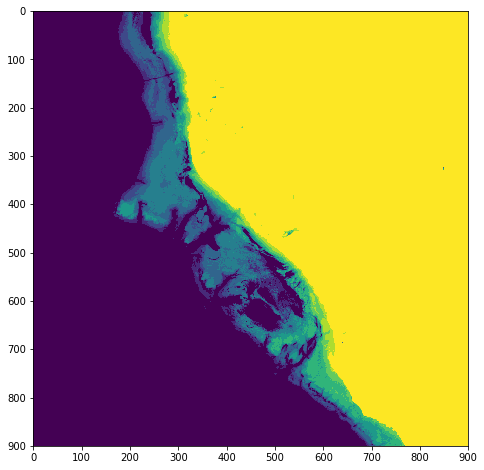

-1220.0

In [68]:
# Import raster and extract shape, projection info and geotransform data
item_filename = glob.glob('{}/ITEM_REL_{}_*.tif'.format(item_relative_path, polygon_ID))[0]
item_ds = gdal.Open(item_filename)
item_array = item_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = item_array.shape
prj = item_ds.GetProjection()
geotrans = item_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Assign nodata -6666 values to new class 10 prior to lookup classification
item_array[item_array == -6666] = 10
 
# Create lookup index array, and index by ITEM relative layer to classify into offset values
# (this method should be resilient to ITEM layers with fewer than 9 classes)
lookup_index = np.array([interval_zero] + interval_offsets + [np.nan])
offset_array = lookup_index[item_array]

# Contours generated by `skimage.measure.find_contours` stop before the edge of nodata pixels. To prevent
# gaps from occurring between adjacent NIDEM tiles, the following steps 'fill' pixels directly on the boundary
# of two NIDEM tiles with the value of the nearest pixel with data. First, identify areas to be filled by dilating
# non-NaN pixels by two pixels (i.e. ensuring vertical, horizontal and diagonally adjacent pixels are filled):
dilated_mask = nd.morphology.binary_dilation(~np.isnan(offset_array), iterations=2)

# For every pixel, identify the indices of the nearest pixel with data (i.e. data pixels will return their own
# indices; nodata pixels will return the indices of the nearest data pixel). This output can be used to index back
# into the original array, returning a new array where data pixels remain the same, but every nodata pixel isn
# filled with the value of the nearest data pixel:
nearest_inds = nd.distance_transform_edt(input=np.isnan(offset_array), return_distances=False, return_indices=True)
offset_array = offset_array[tuple(nearest_inds)]

# Since we only want to fill pixels on the boundary of NIDEM tiles, set pixels outside the dilated area back to NaN:
offset_array[~dilated_mask] = np.nan

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(offset_array[plotting_subset])  
plt.show()



## Compute ITEM confidence and elevation/bathymetry masks
The following code applies a range of masks to remove pixels where elevation values are likely to be invalid:

1. Non-coastal pixels with elevations greater than 25 m above MSL. This mask is computed using [SRTM-derived 1 Second Digital Elevation Model data](http://pid.geoscience.gov.au/dataset/ga/69769).
2. Deep water pixels with bathymetry values less than -25 m below MSL. This mask is computed by identifying any < -25 m pixels in both the national [Australian Bathymetry and Topography Grid](http://pid.geoscience.gov.au/dataset/ga/67703) and the [GBR30 bathymetry](http://pid.geoscience.gov.au/dataset/ga/115066) datasets.
3. Pixels with high ITEM confidence NDWI standard deviation (i.e. areas where inundation patterns are not driven by tidal influences). This mask is computed using ITEM v2.0 confidence layer data from DEA. 

In a small number of locations where these masks remove valid data, a manual shapefile mask is used to preserve these pixels in the final datasets.

Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/temp.tif
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/temp.tif
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/temp.tif


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Exporting NIDEM mask for polygon 96


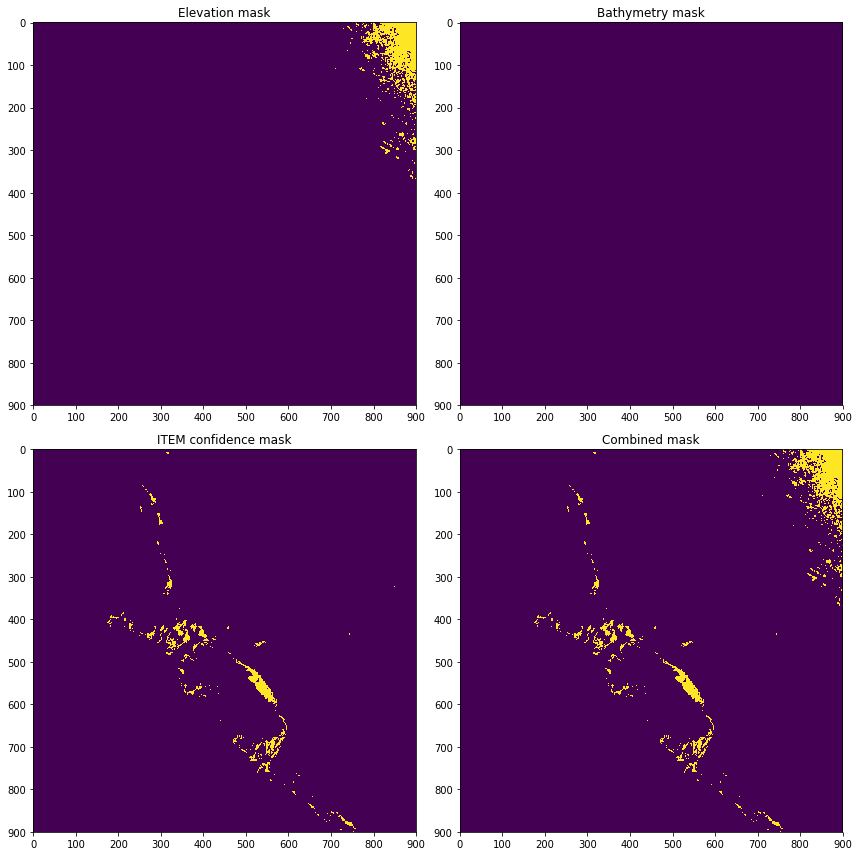

In [65]:
# Import ITEM confidence NDWI standard deviation array for polygon
conf_filename = glob.glob('{}/ITEM_STD_{}_*.tif'.format(item_conf_path, polygon_ID))[0]
conf_ds = gdal.Open(conf_filename)

# Reproject SRTM-derived 1 Second DEM to cell size and projection of NIDEM
srtm30_reproj = SpatialTools.reproject_to_template(input_raster=srtm30_raster,
                                                  template_raster=item_filename, 
                                                  output_raster='scratch/temp.tif', 
                                                  nodata_val=-9999) 

# Reproject Australian Bathymetry and Topography Grid to cell size and projection of NIDEM
ausbath09_reproj = SpatialTools.reproject_to_template(input_raster=ausbath09_raster,
                                                      template_raster=item_filename, 
                                                      output_raster='scratch/temp.tif', 
                                                      nodata_val=-9999) 

# Reproject GBR30 bathymetry to cell size and projection of NIDEM
gbr30_reproj = SpatialTools.reproject_to_template(input_raster=gbr30_raster,
                                                  template_raster=item_filename, 
                                                  output_raster='scratch/temp.tif', 
                                                  nodata_val=-9999) 

# Import shapefile of areas to manually include in the output datasets and convert to 
# raster with same cell size and projection of NIDEM
manually_included = SpatialTools.rasterize_vector(input_data=manually_included_shp, 
                                                  cols=xcols, rows=yrows,
                                                  geo_transform=geotrans, 
                                                  projection=prj).astype(np.bool)

# Convert raster datasets to arrays
conf_array = conf_ds.GetRasterBand(1).ReadAsArray() 
srtm30_array = srtm30_reproj.GetRasterBand(1).ReadAsArray()
ausbath09_array = ausbath09_reproj.GetRasterBand(1).ReadAsArray()
gbr30_array = gbr30_reproj.GetRasterBand(1).ReadAsArray()

# Convert arrays to boolean masks:
#  For elevation: any elevations > 25m in SRTM 30m DEM
#  For bathymetry: any depths < -25m in both GBR30 and Ausbath09 bathymetry
#  For ITEM confidence: any cells with NDWI STD > 0.25
elev_mask = srtm30_array > 25
bathy_mask = (ausbath09_array < -25) & (gbr30_array < -25)
conf_mask = conf_array > 0.25

# Create a combined mask with -9999 nodata in unmasked areas and where:
#  1 = elevation mask
#  2 = bathymetry mask
#  3 = ITEM confidence mask
combined_mask = np.full(item_array.shape, -9999)
combined_mask[elev_mask] = 1
combined_mask[bathy_mask] = 2
combined_mask[conf_mask] = 3

# Set manually included pixels to -9999 to prevent masking
combined_mask[manually_included] = -9999

# Plot 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (12, 12))
axes[0][0].set_title('Elevation mask')
axes[0][0].imshow(elev_mask[plotting_subset])
axes[0][1].set_title('Bathymetry mask')
axes[0][1].imshow(bathy_mask[plotting_subset])
axes[1][0].set_title('ITEM confidence mask')
axes[1][0].imshow(conf_mask[plotting_subset])
axes[1][1].set_title('Combined mask')
axes[1][1].imshow(combined_mask[plotting_subset])
plt.tight_layout()

# Export NIDEM mask as a geotiff
print('Exporting NIDEM mask for polygon {}'.format(polygon_ID))
SpatialTools.array_to_geotiff(fname = 'output_data/mask/NIDEM_mask_{}.tif'.format(polygon_ID), 
                              data = combined_mask, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = -9999)


## Extract contours
Uses `skimage.measure.find_contours` to rapidly extract contour boundaries between ITEM tidal intervals, and assigns these contours with previously calculated elevation values. Contours are exported as line shapefiles to assist in subsequent assessment of output DEMs.

In [56]:
# Output dict to hold contours for each offset
contour_dict = collections.OrderedDict()

try:
    
    for contour_offset in contour_offsets:

        # Extract contours from array
        contours = skimage.measure.find_contours(offset_array, contour_offset)      
        print('Extracting contour {}'.format(contour_offset))
        
        # Iterate through each contour feature, remove NAs and fix coordinates
        contour_list = list()
        for contour in contours:

            # Convert index coordinates to spatial coordinates in-place
            contour[:, 0] = contour[:, 0] * float(y_size) + upleft_y + (float(y_size) / 2)
            contour[:, 1] = contour[:, 1] * float(x_size) + upleft_x + (float(x_size) / 2)        
            contour = np.insert(contour, 2, contour_offset, axis = 1)

            # Remove contour points with NAs
            contour = contour[~np.isnan(contour).any(axis=1)] 
            contour_list.append(contour)

        # Add list of contour arrays to dict 
        contour_dict[contour_offset] = contour_list
        
except:
    
    print('Contour creation failed')

    
# Export contours to line shapefile to assist in evaluating DEMs
schema = {'geometry':  'MultiLineString', 
          'properties': { 'elevation': 'int' } }      

with fiona.open('output_data/contour/NIDEM_contours_{}.shp'.format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = 'ESRI Shapefile', 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # Filter out contours with less than two points (i.e. non-lines)
        contour_list = [x for x in contour_list if len(x) > 1]
        
        # Create multiline string by first flipping coordinates then creating list of linestrings
        contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array]) 
                               for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': int(elevation_value) },
                      'geometry': mapping(contour_multilinestring) })
        
# Chain and concatenate all arrays nested within array lists (i.e. individual collections of same 
# elevation contours) and dictionary entries (i.e. collections of all same-elevation contours)
all_contours = np.concatenate(list(itertools.chain.from_iterable(contour_dict.values())))
points = all_contours[:, 0:2]
values = all_contours[:, 2]


Extracting contour -1125
Extracting contour -936
Extracting contour -747
Extracting contour -557
Extracting contour -368
Extracting contour -178
Extracting contour 10
Extracting contour 199
Extracting contour 389
Extracting contour 578


## Interpolate contours using TIN/Delaunay triangulation interpolation
Generates continuous elevation surfaces by interpolating between the extracted contours. This uses the linear method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using Qhull before performing linear barycentric interpolation on each triangle.

Because the lowest and highest ITEM intervals cannot be correctly interpolated as they have no lower or upper bounds, the resulting NIDEM is constrained to valid intertidal terrain (ITEM intervals 1-8). NIDEM is exported as two DEMs: an unfiltered version, and a version filtered to remove > +25 m or < -25 m terrain and pixels with high ITEM confidence NDWI standard deviation.

Interpolating data for polygon 96
Exporting unfiltered NIDEM for polygon 96
Exporting filtered NIDEM for polygon 96


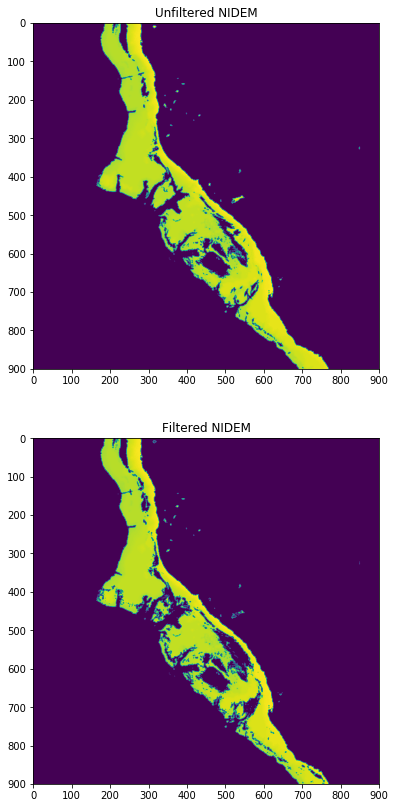

In [59]:
# Calculate bottom right bounds of ITEM layer
bottomright_x = upleft_x + (x_size * xcols)
bottomright_y = upleft_y + (y_size * yrows)

# Create interpolation grid (from-to-by values in metre units)
grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
print('Interpolating data for polygon {}'.format(polygon_ID))
interpolated_array = scipy.interpolate.griddata(points, values, (grid_y, grid_x), method='linear')

# Identify valid intertidal area by selecting pixels between the lowest and highest ITEM intervals
valid_intertidal_extent = np.where((item_array > 0) & (item_array < 9), 1, 0)

# Create filtered and unfiltered versions of NIDEM
nidem_unfiltered = np.where(valid_intertidal_extent, interpolated_array, -9999).astype(np.float32)
nidem_filtered = np.where(combined_mask > 0, -9999, nidem_unfiltered).astype(np.float32)

# Export unfiltered NIDEM as a geotiff
print('Exporting unfiltered NIDEM for polygon {}'.format(polygon_ID))
SpatialTools.array_to_geotiff(fname = 'output_data/dem_unfiltered/NIDEM_unfiltered_{}.tif'.format(polygon_ID), 
                              data = nidem_unfiltered, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = -9999)

# Export filtered NIDEM as a geotiff
print('Exporting filtered NIDEM for polygon {}'.format(polygon_ID))
SpatialTools.array_to_geotiff(fname = 'output_data/dem/NIDEM_dem_{}.tif'.format(polygon_ID), 
                              data = nidem_filtered, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = -9999)

# Plot output interpolated and masked DEM
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 14))
ax1.imshow(nidem_unfiltered[plotting_subset], interpolation='bilinear')
ax1.set_title('Unfiltered NIDEM')
ax2.imshow(nidem_filtered[plotting_subset], interpolation='bilinear')
ax2.set_title('Filtered NIDEM')
plt.show()

# Close files
conf_ds = None
item_ds = None
gbr30_reproj = None
ausbath09_reproj = None
srtm30_reproj = None


In [60]:
!jupyter nbconvert --to script NIDEM_generation.ipynb

[NbConvertApp] Converting notebook NIDEM_generation.ipynb to script
[NbConvertApp] Writing 19399 bytes to NIDEM_generation.py
